In [1]:
import pandas as pd

In [2]:
path = "dummy_historic_data.csv"
data = pd.read_csv(path)
data.head()

,user_id,transaction_id,timestamp,amount,device_type,location,is_vpn,fraud
0,U47935,T97D7AE2A,2022-01-01T00:10:27,74.47,tablet,"California, USA",True,False
1,U45203,T1B97D873,2022-01-01T00:12:18,420.23,mobile,"London, UK",False,False
2,U26878,T9D67FE01,2022-01-01T00:15:59,288.41,tablet,"California, USA",False,False
3,U98609,T073EBAF8,2022-01-01T00:23:34,981.99,tablet,"California, USA",True,False
4,U90290,T2E2A2FAF,2022-01-01T00:29:52,372.75,mobile,"New York, USA",False,False


In [3]:
print("total users in the dataset ", len(data['user_id'].unique()))
print("row count", len(data.index))

total users in the dataset  60348
row count 1439501


In [4]:
data.groupby("user_id", as_index=False) \
    .agg({"transaction_id": "count"}) \
    .sort_values(by="transaction_id", ascending=False)


,user_id,transaction_id
36301,U64183,204
10334,U25416,194
56933,U94942,193
16640,U34913,186
41420,U71838,171
...,...,...
60340,U99991,1
60317,U99953,1
60315,U99950,1
60312,U99944,1


In [6]:
data['fraud'].value_counts()

fraud
False    1410722
True       28779
Name: count, dtype: int64

In [7]:
data.groupby(by="fraud")['amount'].describe()

,count,mean,std,min,25%,50%,75%,max
fraud,,,,,,,,
False,1410722.0,500.596636,288.486393,1.00,250.440,501.14,750.190,1000.00
True,28779.0,502.323139,288.313929,1.03,249.965,505.92,750.995,999.99


In [8]:
data.groupby(by="fraud")['device_type'].describe()

,count,unique,top,freq
fraud,,,,
False,1410722,3,desktop,470714
True,28779,3,mobile,9694


In [9]:
data.groupby(by="fraud")['is_vpn'].describe()

,count,unique,top,freq
fraud,,,,
False,1410722,2,True,706243
True,28779,2,True,14498


In [10]:
data.groupby(by="fraud")['location'].describe()

,count,unique,top,freq
fraud,,,,
False,1410722,7,"London, UK",202020
True,28779,7,"Texas, USA",4180


In [13]:
data.groupby(by=["location", "fraud"], as_index=False)['transaction_id'].count()

,location,fraud,transaction_id
0,"Berlin, Germany",False,201040
1,"Berlin, Germany",True,4072
2,"California, USA",False,201725
3,"California, USA",True,4113
4,"London, UK",False,202020
5,"London, UK",True,4082
6,"New York, USA",False,201734
7,"New York, USA",True,4016
8,"Ontario, Canada",False,201697
9,"Ontario, Canada",True,4154


Since this is just randomly generated data there is no pattern here, the data is fairly distributed thanks to `random.choice` function and due to lack of time I am not going to try to create another generation function to do anything, lets build a basic model

In [28]:
data["date"] = pd.to_datetime(data["timestamp"]).dt.date
transaction_per_day = data.groupby(by="date")['transaction_id'].count()
transaction_per_day

date
2022-01-01     134
2022-01-02     150
2022-01-03     126
2022-01-04     123
2022-01-05     142
              ... 
2023-12-27    3758
2023-12-28    3788
2023-12-29    3810
2023-12-30    3766
2023-12-31     129
Name: transaction_id, Length: 730, dtype: int64

<Axes: xlabel='date'>

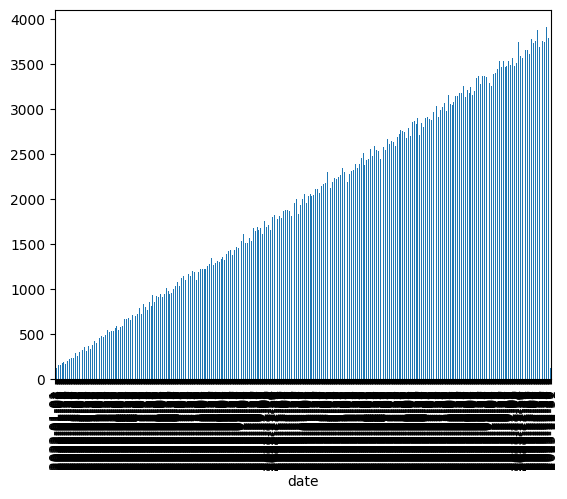

In [29]:
transaction_per_day.plot(kind='bar')

##### The data is increasing over time thanks to the data generation but what we really need to figure out how much data is there weekly so that we can figure out how to split it up

In [35]:
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['week'] = data['timestamp'].dt.to_period('W')
data['month'] = data['timestamp'].dt.to_period('M')

weekly_counts = (
    data.groupby('week')['transaction_id']
      .count()
)

monthly_counts = (
    data.groupby('month')['transaction_id']
      .count()
)



<Axes: xlabel='week'>

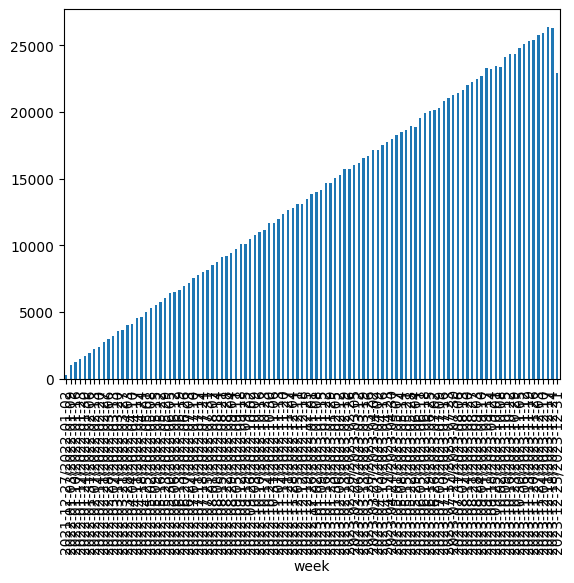

In [37]:
weekly_counts.plot(kind='bar')

<Axes: xlabel='month'>

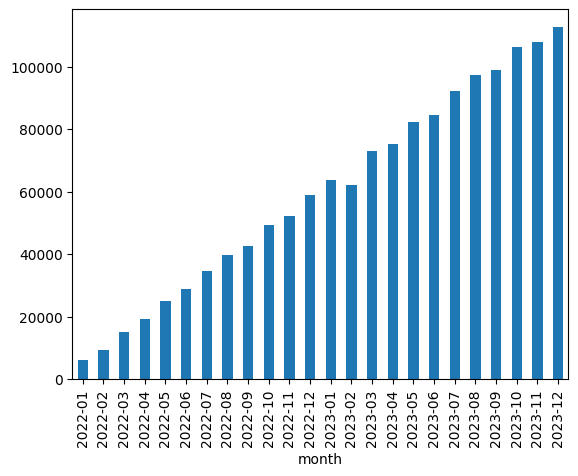

In [38]:
monthly_counts.plot(kind='bar')

We can work with last 4 months of data, using 2 weeks to train, 2 weeks to validate and 2 weeks to test and do it 3 fold